O primeiro passo é importar os dados que foram disponibilizados no Kaggle (Home Credit Stability Model Competition), por isso, utilizando a API do Kaggle, importaremos apenas os dados parquet (pois são mais leves).

In [ ]:
!kaggle competitions download -c home-credit-credit-risk-model-stability -p ../data/


  0%|          | 0.00/3.14G [00:00<?, ?B/s]
  0%|          | 1.00M/3.14G [00:00<07:46, 7.23MB/s]
  2%|▏         | 51.0M/3.14G [00:00<00:12, 263MB/s] 
  3%|▎         | 95.0M/3.14G [00:00<00:09, 343MB/s]
  4%|▍         | 131M/3.14G [00:00<00:09, 337MB/s] 
  5%|▌         | 177M/3.14G [00:00<00:08, 385MB/s]
  7%|▋         | 218M/3.14G [00:00<00:07, 399MB/s]
  8%|▊         | 264M/3.14G [00:00<00:07, 425MB/s]
 10%|▉         | 307M/3.14G [00:00<00:07, 430MB/s]
 11%|█         | 349M/3.14G [00:00<00:07, 426MB/s]
 12%|█▏        | 390M/3.14G [00:01<00:07, 393MB/s]
 13%|█▎        | 429M/3.14G [00:01<00:08, 338MB/s]
 15%|█▍        | 470M/3.14G [00:01<00:07, 361MB/s]
 16%|█▌        | 520M/3.14G [00:01<00:07, 403MB/s]
 18%|█▊        | 566M/3.14G [00:01<00:06, 423MB/s]
 19%|█▉        | 608M/3.14G [00:01<00:06, 408MB/s]
 20%|██        | 648M/3.14G [00:01<00:07, 375MB/s]
 21%|██▏       | 685M/3.14G [00:01<00:07, 365MB/s]
 22%|██▏       | 721M/3.14G [00:02<00:08, 298MB/s]
 24%|██▎       | 758M/3.14G [00


Extraídos 68 arquivos '.parquet' em 'C:\Users\raulw\Documents\projetos\entregas\credit-risk-tec-case-pwd\data\parquet_files'


In [1]:
# pega o diretório pai (projeto) e adiciona ao path
import sys, os
proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

import importlib
import funcs.aux_utils as f_aux
importlib.reload(f_aux)
from pathlib import Path

ZIP_PATH = Path("../data/home-credit-credit-risk-model-stability.zip")
DEST_DIR = Path("../data/parquet_files")
EXTENSION = ".parquet"

In [2]:
handler = f_aux.HandleData()
handler.unzip_files(
    zip_path = ZIP_PATH,
    extension = EXTENSION,
    dest_dir  =  DEST_DIR# opcional
)

Extraídos 68 arquivos '.parquet' em 'C:\Users\raulw\Documents\projetos\entregas\credit-risk-tec-case-pwd\data\parquet_files'


In [26]:
import pandas as pd
import numpy as np
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings

filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)


pl.Config(
    **dict(
        tbl_formatting="ASCII_FULL_CONDENSED",
        tbl_hide_column_data_types=True,
        tbl_hide_dataframe_shape=True,
        fmt_float="mixed",
        tbl_cell_alignment="CENTER",
        tbl_hide_dtype_separator=True,
        tbl_cols=100,
        tbl_rows=None,
        fmt_str_lengths=100,
    )
)


# Sobre os dados

Em decorrência da quantidade de tabelas e de colunas, será necessário a construção de um Pipeline e de uma classe auxiliar para lidar com esta quantidade massiva de dados.

O primeiro ponto da análise dos dados é verificar a distribuição da variável alvo e quantidade de missings das tabelas de treino(target). 

Por isso, primeiro verificarei a distribuição do target. Após isso realizar a separação do conjunto de validação e de teste estratificado com base na distribuição do variável alvo.

In [4]:
data = pl.read_parquet(f'{DEST_DIR}/train_base.parquet')


print(data.n_unique())
data.head()

1526659


case_id,date_decision,MONTH,WEEK_NUM,target
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1


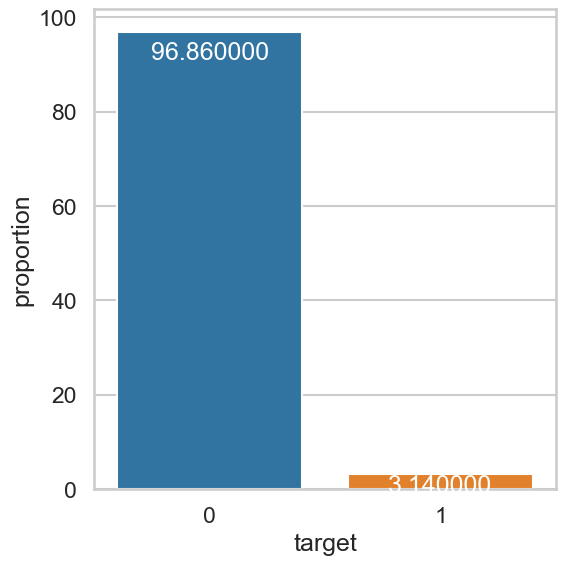

Proporção do target
Clientes não inadimplentes (em %): 96.86
Clientes não inadimplentes (em %): 3.14


In [5]:
chart_maker = f_aux.ChartMaker(figure_size=(6, 6))

count_target = data['target'].value_counts(normalize=True)
count_target = count_target.with_columns([
    (pl.col('proportion') * 100).round(2).alias('proportion')
])

chart_maker.plot_bar_chart(X=count_target['target'], y=count_target['proportion'])

print('Proporção do target')
print(f'Clientes não inadimplentes (em %): {count_target['proportion'][0]}')
print(f'Clientes não inadimplentes (em %): {count_target['proportion'][1]}')

del chart_maker

Podemos ver que a classe alvo é bastante desbalanceada, tendo cerca de apenas 3,1% dos clientes inadimplementes. Denota-se então a necessidade da aplicação e cuidado de técnicas de modo a não enviesar o modelo e causar um overfit a respeito do conjunto de treinamento. Dessa forma, para garantir que o processo de EDA e de criação do modelo esteja seguro de vazamento de dados, separaremos o conjunto de dados em: 

    1. Treino
    2. Validação
    3. Teste

Utilizaremos a função train_test_split do scikit-learn com o parâmetro "stratify" aplicado em virtude do desbalanceamento do target.

In [6]:
from sklearn.model_selection import train_test_split

X = data.drop(['target', 'WEEK_NUM', 'MONTH'])
y = data['target']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.25, random_state=42)

print(f'Shape do conjunto de variáveis preditoras de treinamento: {X_train.shape} | proporção: {X_train.shape[0] / data.shape[0] * 100:.2f}')
print(f'Shape do conjunto de variáveis preditoras de validação: {X_val.shape} | proporção: {X_val.shape[0] / data.shape[0] * 100:.2f} ')
print(f'Shape do conjunto de variáveis preditoras de teste: {X_test.shape} | proporção: {X_test.shape[0] / data.shape[0] * 100:.2f} ')
print(f'Shape da variável alvo de treinamento: {y_train.shape} | proporção: {y_train.shape[0] / data.shape[0] * 100:.2f} ')
print(f'Shape da variável alvo de validação: {y_val.shape} | proporção: {y_val.shape[0] / data.shape[0] * 100:.2f} ')
print(f'Shape da variável alvo de test: {y_test.shape} | proporção: {y_test.shape[0] / data.shape[0] * 100:.2f} ')

train = X_train.with_columns(y_train)
val = X_val.with_columns(y_val)
test = X_test.with_columns(y_test)

Shape do conjunto de variáveis preditoras de treinamento: (915995, 2) | proporção: 60.00
Shape do conjunto de variáveis preditoras de validação: (305332, 2) | proporção: 20.00 
Shape do conjunto de variáveis preditoras de teste: (305332, 2) | proporção: 20.00 
Shape da variável alvo de treinamento: (915995,) | proporção: 60.00 
Shape da variável alvo de validação: (305332,) | proporção: 20.00 
Shape da variável alvo de test: (305332,) | proporção: 20.00 


Separados em seus respectivos conjuntos, vamos avaliar quantos valores missing o conjunto de treino possui. Além disso, vamos verificar as tabelas que temos e quais seus respectivos shapes e quantidade de missings também.

In [7]:
missings = train.null_count()

missings

case_id,date_decision,target
0,0,0


In [ ]:
parquets = list(Path("../data/parquet_files").glob("*.parquet"))
print("Arquivos disponíveis:", [p.name for p in parquets])


records = []
for p in parquets:
    df = pl.read_parquet(p)

    display(df.head(3))

    table_name = p.stem
    total_rows, _ = df.shape


    for col in df.columns:
        null_count = df[col].is_null().sum()
        if total_rows > 0:
            null_ratio = round(null_count / total_rows, 4)
        else:
            null_ratio = None

        records.append({
            "table":      table_name,
            "column":     col,
            "dtype":      str(df.schema[col]),
            "null_count": int(null_count),
            "null_ratio": null_ratio
        })

Arquivos disponíveis: ['test_applprev_1_0.parquet', 'test_applprev_1_1.parquet', 'test_applprev_1_2.parquet', 'test_applprev_2.parquet', 'test_base.parquet', 'test_credit_bureau_a_1_0.parquet', 'test_credit_bureau_a_1_1.parquet', 'test_credit_bureau_a_1_2.parquet', 'test_credit_bureau_a_1_3.parquet', 'test_credit_bureau_a_1_4.parquet', 'test_credit_bureau_a_2_0.parquet', 'test_credit_bureau_a_2_1.parquet', 'test_credit_bureau_a_2_10.parquet', 'test_credit_bureau_a_2_11.parquet', 'test_credit_bureau_a_2_2.parquet', 'test_credit_bureau_a_2_3.parquet', 'test_credit_bureau_a_2_4.parquet', 'test_credit_bureau_a_2_5.parquet', 'test_credit_bureau_a_2_6.parquet', 'test_credit_bureau_a_2_7.parquet', 'test_credit_bureau_a_2_8.parquet', 'test_credit_bureau_a_2_9.parquet', 'test_credit_bureau_b_1.parquet', 'test_credit_bureau_b_2.parquet', 'test_debitcard_1.parquet', 'test_deposit_1.parquet', 'test_other_1.parquet', 'test_person_1.parquet', 'test_person_2.parquet', 'test_static_0_0.parquet', 'test

case_id,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,creationdate_885D,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,credacc_minhisbal_90A,credacc_status_367L,credacc_transactions_402L,credamount_590A,credtype_587L,currdebt_94A,dateactivated_425D,district_544M,downpmt_134A,dtlastpmt_581D,dtlastpmtallstes_3545839D,education_1138M,employedfrom_700D,familystate_726L,firstnonzeroinstldate_307D,inittransactioncode_279L,isbidproduct_390L,isdebitcard_527L,mainoccupationinc_437A,maxdpdtolerance_577P,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L
57543,0.0,935.2,"""2018-10-24""",null,"""a55475b1""",null,"""2018-10-24""",null,0.0,null,null,null,null,8398.0,"""COL""",0.0,"""2018-11-06""","""P98_137_111""",0.0,"""2019-07-24""","""2019-07-24""","""P33_146_175""","""2011-01-01""","""SINGLE""","""2018-11-24""","""POS""",false,null,30000.0,0.0,3,0.0,11.0,"""P177_117_192""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""K""",11.0
57543,0.0,1218.2001,"""2021-01-13""",null,"""a55475b1""",null,"""2021-01-13""",null,0.0,null,null,null,null,14960.0,"""COL""",12154.4,"""2021-01-14""","""P59_55_87""",0.0,null,"""2021-05-15""","""P106_81_188""",null,"""SINGLE""","""2021-02-13""","""POS""",false,null,34000.0,1.0,1,12154.4,14.0,"""P60_146_156""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""A""",14.0
57543,0.0,1892.0,"""2014-10-13""",1.0,"""a55475b1""",1.0,"""2014-10-13""",null,0.0,null,null,null,null,20000.0,"""CAL""",0.0,"""2014-10-13""","""P98_137_111""",0.0,"""2016-04-13""","""2016-04-13""","""P33_146_175""","""2011-07-01""","""MARRIED""","""2014-11-13""","""CASH""",false,null,30000.0,1.0,8,0.0,18.0,"""P46_145_78""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""K""",18.0


case_id,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,creationdate_885D,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,credacc_minhisbal_90A,credacc_status_367L,credacc_transactions_402L,credamount_590A,credtype_587L,currdebt_94A,dateactivated_425D,district_544M,downpmt_134A,dtlastpmt_581D,dtlastpmtallstes_3545839D,education_1138M,employedfrom_700D,familystate_726L,firstnonzeroinstldate_307D,inittransactioncode_279L,isbidproduct_390L,isdebitcard_527L,mainoccupationinc_437A,maxdpdtolerance_577P,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L
57549,0.0,0.0,null,null,"""P94_109_143""",null,"""2018-05-05""",34066.0,34066.0,0.0,0.0,"""CL""",0.0,7178.0,"""REL""",null,null,"""P158_150_171""",0.0,null,null,"""a55475b1""",null,null,null,"""POS""",false,false,20000.0,null,7,null,24.0,"""P177_117_192""","""a55475b1""","""P94_109_143""","""P94_109_143""",null,"""D""",24.0
57549,0.0,0.0,"""2021-10-12""",null,"""a55475b1""",null,"""2021-10-12""",null,0.0,null,null,null,null,0.0,"""REL""",0.0,null,"""P158_150_171""",0.0,null,"""2022-01-13""","""a55475b1""",null,null,null,"""NDF""",false,true,null,0.0,2,0.0,null,"""P46_145_78""","""a55475b1""","""a55475b1""","""a55475b1""",8.400498e8,"""N""",null
57549,0.0,0.0,"""2021-08-18""",null,"""a55475b1""",null,"""2021-08-18""",null,17800.0,null,null,null,null,17800.0,"""REL""",0.0,null,"""P121_131_159""",0.0,"""2021-10-13""","""2021-10-13""","""P106_81_188""",null,"""SINGLE""",null,"""NDF""",false,false,60000.0,0.0,4,0.0,null,"""P46_145_78""","""a55475b1""","""a55475b1""","""a55475b1""",8.207819e8,"""K""",null


case_id,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,creationdate_885D,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,credacc_minhisbal_90A,credacc_status_367L,credacc_transactions_402L,credamount_590A,credtype_587L,currdebt_94A,dateactivated_425D,district_544M,downpmt_134A,dtlastpmt_581D,dtlastpmtallstes_3545839D,education_1138M,employedfrom_700D,familystate_726L,firstnonzeroinstldate_307D,inittransactioncode_279L,isbidproduct_390L,isdebitcard_527L,mainoccupationinc_437A,maxdpdtolerance_577P,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L
57760,0.0,0.0,"""2016-09-05""",null,"""a55475b1""",1.0,"""2016-09-05""",0.0,0.0,0.0,0.0,"""AC""",0.0,100000.0,"""REL""",0.0,"""2016-09-22""","""P117_87_136""",0.0,"""2018-07-14""","""2018-07-14""","""P33_146_175""","""2009-08-02""","""MARRIED""",null,"""NDF""",true,false,32000.0,18.0,6,0.0,null,"""P46_145_78""","""a55475b1""","""a55475b1""","""a55475b1""",7.4259565e8,"""K""",null
57760,0.0,0.0,"""2020-06-15""",null,"""a55475b1""",null,"""2020-06-15""",null,0.0,null,null,null,null,0.0,"""REL""",0.0,"""2020-08-07""","""P117_87_136""",0.0,null,"""2020-06-15""","""a55475b1""",null,null,null,"""NDF""",false,true,null,0.0,0,0.0,null,"""P46_145_78""","""a55475b1""","""a55475b1""","""a55475b1""",8.2037786e8,"""A""",null
57760,0.0,0.0,"""2020-06-15""",null,"""a55475b1""",null,"""2020-06-15""",null,0.0,null,null,null,null,0.0,"""REL""",0.0,"""2020-08-07""","""P117_87_136""",0.0,null,"""2020-06-15""","""a55475b1""",null,null,null,"""NDF""",false,true,null,0.0,1,0.0,null,"""P46_145_78""","""a55475b1""","""a55475b1""","""a55475b1""",8.203778e8,"""A""",null


case_id,cacccardblochreas_147M,conts_type_509L,credacc_cards_status_52L,num_group1,num_group2
57543,"""a55475b1""","""PRIMARY_MOBILE""",null,0,0
57543,"""a55475b1""",null,null,0,1
57543,"""a55475b1""","""PRIMARY_MOBILE""",null,1,0


case_id,date_decision,MONTH,WEEK_NUM
57543,"""2021-05-14""",202201,100
57549,"""2022-01-17""",202201,100
57551,"""2020-11-27""",202201,100


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,numberofcontrsvalue_358L,numberofinstls_229L,numberofinstls_320L,numberofoutstandinstls_520L,numberofoutstandinstls_59L,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
57551,8.28,null,"""a55475b1""","""ea6782cc""","""a55475b1""","""7241344e""",null,null,null,null,"""2023-07-02""","""2018-09-10""",null,"""2020-06-20""",null,null,"""a55475b1""",null,3.0,11.0,null,null,2018.0,"""P133_127_114""","""a55475b1""",null,null,null,null,"""2020-06-24""",null,18292.4,null,31.0,13,null,null,18.0,null,0.0,null,null,3.0,"""2018-11-04""",null,null,0.0,0.0,null,0.0,null,null,10429.616,"""2020-01-01""",null,null,10429.616,1.0,null,null,2020.0,30.0,null,null,null,"""a55475b1""","""96a8fdfe""",null,null,null,"""a55475b1""","""a55475b1""",398551.03,null,null,null,null,null
57551,null,null,"""ea6782cc""","""d7416962""","""7241344e""","""7241344e""",88957.0,null,53375.0,"""2021-06-24""","""2010-03-21""","""2007-03-21""","""2019-06-24""","""2008-12-08""",585239.06,0.0,"""a55475b1""",0.0,1.0,11.0,7.0,2019.0,2008.0,"""P40_52_135""","""b619fa46""",17791.4,null,null,"""2020-11-24""","""2008-12-20""",17791.4,0.0,null,null,0,2.0,16.0,36.0,null,0.0,null,0.0,1.0,"""2008-10-12""",null,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,null,null,0.0,0.0,6.0,7.0,2019.0,2007.0,30.0,null,null,null,"""60c73645""","""5065c2b8""","""2020-12-11""",null,17791.4,"""ab3c25cf""","""ab3c25cf""",58000.0,null,0.0,0.0,585239.06,0.0
57551,null,null,"""ea6782cc""","""42a42e75""","""7241344e""","""7241344e""",2837238.3,null,600000.0,"""2025-06-18""","""2007-11-10""","""2007-08-13""","""2020-06-18""","""2007-11-09""",null,null,"""a55475b1""",0.0,0.0,9.0,7.0,2020.0,2007.0,"""b619fa46""","""P150_136_157""",15073.328,null,null,"""2020-12-03""","""2007-12-07""",15073.328,null,null,null,1,null,null,6.0,null,0.0,null,0.0,0.0,null,null,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,null,null,0.0,0.0,9.0,7.0,2020.0,2007.0,30.0,null,null,null,"""96a8fdfe""","""5065c2b8""","""2020-12-11""",null,567447.7,"""a55475b1""","""a55475b1""",11348.0,null,null,null,null,null


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,numberofcontrsvalue_358L,numberofinstls_229L,numberofinstls_320L,numberofoutstandinstls_520L,numberofoutstandinstls_59L,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
57543,0.69,null,"""a55475b1""","""01f63ac8""","""a55475b1""","""7241344e""",null,null,null,null,"""2019-12-24""","""2019-12-06""",null,"""2019-12-24""",null,null,"""a55475b1""",null,0.0,1.0,null,null,2020.0,"""e9bfdb5c""","""a55475b1""",null,null,null,null,"""2019-12-24""",null,8000.0,null,null,11,null,null,1.0,null,0.0,null,null,0.0,null,null,null,0.0,0.0,null,0.0,null,null,0.0,null,null,null,0.0,1.0,null,null,2020.0,30.0,null,0.0,null,"""a55475b1""","""96a8fdfe""",null,null,null,"""a55475b1""","""a55475b1""",8000.0,null,null,null,null,null
57543,null,null,"""ea6782cc""","""01f63ac8""","""7241344e""","""7241344e""",66999.0,null,null,"""2022-03-13""","""2017-12-12""","""2013-12-12""","""2021-01-13""","""2017-07-19""",null,null,"""a55475b1""",0.0,20.0,4.0,2.0,2021.0,2016.0,"""P102_97_118""","""Home Credit""",null,null,null,"""2021-05-05""","""2017-10-02""",1218.2001,0.0,0.0,null,1,null,null,49.0,14.0,0.0,11.0,0.0,22.0,"""2016-03-14""",null,0.0,0.0,0.0,13399.8,0.0,0.0,0.0,820.94006,"""2015-11-23""",null,0.0,820.94006,12.0,2.0,2021.0,2015.0,30.0,30.0,null,null,"""60c73645""","""60c73645""","""2021-05-28""",null,null,"""a55475b1""","""a55475b1""",46000.0,17054.4,null,null,null,null
57543,null,null,"""ea6782cc""","""ea6782cc""","""7241344e""","""7241344e""",84365.0,null,20000.0,"""2022-09-04""","""2013-03-24""","""2011-12-24""","""2020-09-04""","""2013-02-27""",30272.8,0.0,"""a55475b1""",0.0,0.0,2.0,10.0,2020.0,2012.0,"""Home Credit""","""b619fa46""",4725.4,null,null,"""2021-05-19""","""2013-03-02""",4725.4,0.0,null,null,0,2.0,16.0,15.0,null,0.0,null,0.0,0.0,null,null,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,null,null,0.0,0.0,2.0,10.0,2020.0,2012.0,30.0,null,null,null,"""60c73645""","""5065c2b8""","""2021-05-28""",null,16873.0,"""ab3c25cf""","""ab3c25cf""",31031.0,null,0.0,0.0,30272.8,0.0


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,numberofcontrsvalue_358L,numberofinstls_229L,numberofinstls_320L,numberofoutstandinstls_520L,numberofoutstandinstls_59L,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
57633,34.5,34.5,"""ea6782cc""","""ea6782cc""","""7241344e""","""7241344e""",null,null,null,"""2022-12-06""","""2022-08-06""","""2021-08-06""","""2021-12-06""","""2021-10-25""",null,null,"""a55475b1""",0.0,0.0,9.0,1.0,2022.0,2021.0,"""b619fa46""","""b619fa46""",null,null,null,"""2022-01-28""","""2021-11-04""",50662.6,11691.4,29.88,29.88,3,null,null,5.0,10.0,0.0,9.0,0.0,0.0,null,null,0.0,0.0,0.0,305015.34,0.0,0.0,0.0,0.0,null,null,0.0,0.0,9.0,1.0,2022.0,2021.0,30.0,30.0,null,null,"""5d1b0cdd""","""5d1b0cdd""","""2022-02-08""",null,null,"""a55475b1""","""a55475b1""",120000.0,520000.0,null,null,null,null
57633,34.5,34.5,"""ea6782cc""","""ea6782cc""","""7241344e""","""7241344e""",null,null,null,"""2022-12-29""","""2022-09-10""","""2021-09-10""","""2021-12-29""","""2021-11-22""",null,null,"""a55475b1""",0.0,0.0,10.0,1.0,2022.0,2021.0,"""b619fa46""","""b619fa46""",null,null,null,"""2022-01-28""","""2021-11-30""",56508.402,56508.402,29.88,29.88,4,null,null,5.0,12.0,0.0,12.0,0.0,0.0,null,null,0.0,0.0,0.0,491193.5,0.0,0.0,0.0,0.0,null,null,0.0,0.0,10.0,1.0,2022.0,2021.0,30.0,30.0,null,null,"""5d1b0cdd""","""5d1b0cdd""","""2022-02-08""",null,null,"""a55475b1""","""a55475b1""",580000.0,580000.0,null,null,null,null
57633,34.5,34.5,"""ea6782cc""","""ea6782cc""","""7241344e""","""7241344e""",null,null,null,"""2023-01-06""","""2022-10-27""","""2021-10-27""","""2022-01-06""","""2021-11-22""",null,null,"""a55475b1""",0.0,0.0,11.0,2.0,2022.0,2021.0,"""b619fa46""","""b619fa46""",null,null,null,"""2022-01-28""","""2021-11-30""",17537.0,11691.4,29.88,29.88,6,null,null,12.0,12.0,0.0,12.0,0.0,0.0,null,null,0.0,0.0,0.0,163956.98,0.0,0.0,0.0,0.0,null,null,0.0,0.0,11.0,2.0,2022.0,2021.0,30.0,30.0,null,null,"""5d1b0cdd""","""5d1b0cdd""","""2022-01-27""",null,null,"""a55475b1""","""a55475b1""",120000.0,180000.0,null,null,null,null


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,numberofcontrsvalue_358L,numberofinstls_229L,numberofinstls_320L,numberofoutstandinstls_520L,numberofoutstandinstls_59L,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
57549,46.79,null,"""a55475b1""","""ea6782cc""","""a55475b1""","""7241344e""",null,17800.0,null,null,"""2024-08-10""","""2021-08-18""",null,"""2021-10-16""",null,null,"""a55475b1""",null,0.0,1.0,null,null,2022.0,"""Home Credit""","""a55475b1""",null,99.8,null,null,"""2021-10-16""",null,99.8,null,45.0,10.0,null,null,null,null,null,null,null,0.0,null,null,null,0.0,null,null,0.0,null,null,0.0,null,null,null,0.0,1.0,null,null,2022.0,null,null,null,null,"""a55475b1""","""60c73645""",null,0.0,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
57549,657.0,null,"""a55475b1""","""01f63ac8""","""a55475b1""","""7241344e""",null,null,null,null,"""2017-05-08""","""2017-04-08""",null,"""2020-09-19""",null,null,"""a55475b1""",null,0.0,2.0,null,null,2021.0,"""9a93e20f""","""a55475b1""",null,null,null,null,"""2020-09-19""",null,0.0,null,657.0,9.0,null,null,1.0,null,0.0,null,null,0.0,null,null,null,0.0,0.0,null,0.0,null,null,0.0,null,null,null,0.0,2.0,null,null,2021.0,null,null,0.0,null,"""a55475b1""","""96a8fdfe""",null,null,null,"""a55475b1""","""a55475b1""",7000.0,null,null,null,null,null
57549,null,24.37,"""ea6782cc""","""ea6782cc""","""7241344e""","""7241344e""",51777.73,null,null,"""2022-04-11""","""2020-12-06""","""2016-12-06""","""2021-10-12""","""2020-12-07""",null,null,"""a55475b1""",0.0,3.0,12.0,3.0,2022.0,2019.0,"""P150_136_157""","""Home Credit""",null,null,null,"""2022-01-25""","""2020-12-10""",3546.6,0.0,22.0,null,1.0,null,null,0.0,6.0,0.0,3.0,0.0,21.0,"""2017-02-02""",null,0.0,0.0,0.0,10355.546,0.0,0.0,0.0,1744.942,"""2017-01-19""",null,0.0,1611.2361,12.0,3.0,2022.0,2019.0,30.0,30.0,null,null,"""60c73645""","""96a8fdfe""","""2022-01-31""",null,null,"""a55475b1""","""a55475b1""",56000.0,20000.0,null,null,null,null


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,numberofcontrsvalue_358L,numberofinstls_229L,numberofinstls_320L,numberofoutstandinstls_520L,numberofoutstandinstls_59L,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
57760,37.0,null,"""a55475b1""","""ea6782cc""","""a55475b1""","""7241344e""",null,null,null,null,"""2020-11-13""","""2020-06-15""",null,"""2020-11-13""",null,null,"""a55475b1""",null,0.0,7.0,null,null,2021.0,"""Home Credit""","""a55475b1""",null,null,null,null,"""2020-11-13""",null,14092.601,null,31.9,4,null,null,5.0,null,0.0,null,null,0.0,null,null,null,0.0,0.0,null,0.0,null,null,0.0,null,null,null,0.0,7.0,null,null,2021.0,30.0,null,null,null,"""a55475b1""","""60c73645""","""2021-09-13""",null,null,"""a55475b1""","""a55475b1""",247625.61,null,null,null,null,null
57760,42.58,null,"""a55475b1""","""01f63ac8""","""a55475b1""","""7241344e""",null,null,null,null,"""2020-11-09""","""2017-11-09""",null,"""2020-04-01""",null,null,"""a55475b1""",null,281.0,4.0,null,null,2021.0,"""7df02535""","""a55475b1""",null,null,null,null,"""2020-04-01""",null,0.0,null,null,2,null,null,0.0,null,0.0,null,null,313.0,"""2020-03-16""",null,null,0.0,0.0,null,0.0,null,null,3998.0,"""2020-03-16""",null,null,3998.0,4.0,null,null,2021.0,30.0,null,null,null,"""a55475b1""","""96a8fdfe""","""2021-03-01""",null,null,"""a55475b1""","""a55475b1""",100000.0,null,null,null,null,null
57760,null,56.0,"""ea6782cc""","""ea6782cc""","""7241344e""","""7241344e""",1.4215e6,100000.0,320000.0,"""2022-09-08""","""2019-09-02""","""2016-09-05""","""2016-09-08""","""2018-07-26""",284305.88,0.0,"""a55475b1""",0.0,10.0,2.0,11.0,2020.0,2019.0,"""Home Credit""","""b619fa46""",14448.601,867.00995,null,"""2021-09-08""","""2018-07-26""",14448.601,867.00995,20.95,45.0,0,1.0,5.0,null,null,null,null,1.0,11.0,"""2018-01-25""","""2017-09-09""",0.0,0.0,null,null,0.0,0.0,950.618,780.0,"""2018-01-25""","""2017-09-09""",0.0,780.0,2.0,11.0,2020.0,2019.0,null,null,null,null,"""60c73645""","""60c73645""","""2021-09-13""",0.0,284305.88,"""ab3c25cf""","""ab3c25cf""",null,null,0.0,0.0,284305.88,0.0


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
57551,"""9a0c095e""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2019.0,2007.0,"""ab3c25cf""","""ab3c25cf"""
57551,"""8fd95e4b""","""9a0c095e""",0.0,75200.0,"""3cbe86ba""","""c7a5ad39""",1,0,null,null,2.0,2.0,null,null,2020.0,2007.0,"""ab3c25cf""","""ab3c25cf"""
57551,"""a55475b1""","""8fd95e4b""",null,0.0,"""3cbe86ba""","""a55475b1""",5,0,null,null,null,2.0,null,null,null,2012.0,"""ab3c25cf""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
57631,"""9a0c095e""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,0.0,null,2.0,2.0,0.0,null,2019.0,2018.0,"""ab3c25cf""","""ab3c25cf"""
57631,"""a55475b1""","""9a0c095e""",null,0.0,"""c7a5ad39""","""a55475b1""",1,0,null,null,null,2.0,null,null,null,2018.0,"""ab3c25cf""","""a55475b1"""
57631,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,0.0,null,3.0,3.0,0.0,null,2019.0,2018.0,"""a55475b1""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
57681,"""9a0c095e""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,0.0,null,2.0,2.0,0.0,null,2022.0,2017.0,"""ab3c25cf""","""ab3c25cf"""
57681,"""8fd95e4b""","""8fd95e4b""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",1,0,null,null,2.0,2.0,null,null,2022.0,2018.0,"""ab3c25cf""","""ab3c25cf"""
57681,"""8fd95e4b""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",2,0,null,null,2.0,2.0,null,null,2022.0,2019.0,"""ab3c25cf""","""ab3c25cf"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
57696,"""9a0c095e""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2021.0,2021.0,"""ab3c25cf""","""ab3c25cf"""
57696,"""8fd95e4b""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",1,0,null,null,2.0,null,null,null,2021.0,null,"""a55475b1""","""ab3c25cf"""
57696,"""8fd95e4b""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",2,0,null,null,2.0,null,null,null,2021.0,null,"""a55475b1""","""ab3c25cf"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
57632,"""9a0c095e""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2019.0,null,"""a55475b1""","""ab3c25cf"""
57632,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2019.0,null,"""a55475b1""","""a55475b1"""
57632,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,null,null,null,2019.0,null,"""a55475b1""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
57543,"""9a0c095e""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2020.0,2011.0,"""ab3c25cf""","""ab3c25cf"""
57543,"""9a0c095e""","""8fd95e4b""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",1,0,0.0,null,2.0,2.0,0.0,null,2021.0,2015.0,"""ab3c25cf""","""ab3c25cf"""
57543,"""a55475b1""","""9a0c095e""",null,0.0,"""c7a5ad39""","""a55475b1""",2,0,null,null,null,2.0,null,null,null,2015.0,"""ab3c25cf""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
57630,"""8fd95e4b""","""8fd95e4b""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2021.0,2014.0,"""ab3c25cf""","""ab3c25cf"""
57630,"""a55475b1""","""9a0c095e""",null,0.0,"""c7a5ad39""","""a55475b1""",1,0,null,0.0,null,2.0,null,0.0,null,2015.0,"""ab3c25cf""","""a55475b1"""
57630,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,3.0,null,null,2021.0,2014.0,"""a55475b1""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
57569,"""a55475b1""","""9a0c095e""",null,0.0,"""c7a5ad39""","""a55475b1""",0,0,null,null,null,2.0,null,null,null,2019.0,"""ab3c25cf""","""a55475b1"""
57569,"""a55475b1""","""9a0c095e""",null,0.0,"""c7a5ad39""","""a55475b1""",1,0,null,null,null,2.0,null,null,null,2017.0,"""ab3c25cf""","""a55475b1"""
57569,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,null,3.0,null,null,null,2019.0,"""a55475b1""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
57636,"""8fd95e4b""","""8fd95e4b""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2021.0,2018.0,"""ab3c25cf""","""ab3c25cf"""
57636,"""a55475b1""","""9a0c095e""",null,0.0,"""c7a5ad39""","""a55475b1""",1,0,null,null,null,2.0,null,null,null,2018.0,"""ab3c25cf""","""a55475b1"""
57636,"""a55475b1""","""8fd95e4b""",null,0.0,"""c7a5ad39""","""a55475b1""",2,0,null,null,null,2.0,null,null,null,2018.0,"""ab3c25cf""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
57633,"""9a0c095e""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,null,0.0,2.0,2.0,null,0.0,2020.0,2021.0,"""ab3c25cf""","""ab3c25cf"""
57633,"""9a0c095e""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",1,0,null,null,2.0,2.0,0.0,null,2021.0,2021.0,"""ab3c25cf""","""ab3c25cf"""
57633,"""9a0c095e""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",2,0,null,null,2.0,2.0,null,null,2021.0,2021.0,"""ab3c25cf""","""ab3c25cf"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
57645,"""9a0c095e""","""8fd95e4b""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2020.0,2018.0,"""ab3c25cf""","""ab3c25cf"""
57645,"""8fd95e4b""","""8fd95e4b""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",1,0,null,null,2.0,2.0,null,null,2021.0,2018.0,"""ab3c25cf""","""ab3c25cf"""
57645,"""a55475b1""","""9a0c095e""",null,0.0,"""c7a5ad39""","""a55475b1""",2,0,null,null,null,2.0,null,null,null,2019.0,"""ab3c25cf""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
57549,"""9a0c095e""","""8fd95e4b""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2020.0,2018.0,"""ab3c25cf""","""ab3c25cf"""
57549,"""9a0c095e""","""8fd95e4b""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",1,0,null,null,2.0,2.0,null,null,2022.0,2019.0,"""ab3c25cf""","""ab3c25cf"""
57549,"""9a0c095e""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",2,0,null,null,2.0,2.0,null,null,2022.0,2017.0,"""ab3c25cf""","""ab3c25cf"""


case_id,amount_1115A,classificationofcontr_1114M,contractdate_551D,contractmaturitydate_151D,contractst_516M,contracttype_653M,credlmt_1052A,credlmt_228A,credlmt_3940954A,credor_3940957M,credquantity_1099L,credquantity_984L,debtpastduevalue_732A,debtvalue_227A,dpd_550P,dpd_733P,dpdmax_851P,dpdmaxdatemonth_804T,dpdmaxdateyear_742T,installmentamount_644A,installmentamount_833A,instlamount_892A,interesteffectiverate_369L,interestrateyearly_538L,lastupdate_260D,maxdebtpduevalodued_3940955A,num_group1,numberofinstls_810L,overdueamountmax_950A,overdueamountmaxdatemonth_494T,overdueamountmaxdateyear_432T,periodicityofpmts_997L,periodicityofpmts_997M,pmtdaysoverdue_1135P,pmtmethod_731M,pmtnumpending_403L,purposeofcred_722M,residualamount_1093A,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A
57675,1.488e6,"""01f63ac8""","""2020-04-22""","""2035-04-23""","""04bf6e27""","""60e784d6""",null,null,null,"""74bd67a8""",null,null,0.0,1.433179e6,null,null,0.0,11.0,2019.0,null,null,17030.264,null,null,"""2022-01-02""",0.0,2,181.0,0.0,11.0,2019.0,null,"""a0b598e4""",0.0,"""e914c86c""",160.0,"""60c73645""",null,null,null,"""a55475b1""","""a55475b1""",null,null
57675,null,"""ea6782cc""","""2020-06-01""","""2022-06-02""","""7241344e""","""1c9c5356""",220598.0,10000.0,20000.0,"""b619fa46""",2.0,1.0,0.0,null,0.0,0.0,0.0,12.0,2019.0,0.0,182816.69,null,null,null,"""2021-12-27""",0.0,0,null,0.0,12.0,2019.0,null,"""a55475b1""",0.0,"""a55475b1""",null,"""60c73645""",0.0,182816.69,17720.8,"""ab3c25cf""","""ab3c25cf""",220598.0,10000.0
57675,null,"""ea6782cc""","""2012-09-29""","""2022-09-29""","""7241344e""","""1c9c5356""",null,null,200598.0,"""b619fa46""",1.0,19.0,0.0,null,0.0,0.0,37403.0,8.0,2013.0,0.0,1.433179e6,null,null,null,"""2021-12-24""",0.0,1,null,10.6,4.0,2015.0,null,"""a55475b1""",0.0,"""a55475b1""",null,"""60c73645""",null,null,165095.89,"""ab3c25cf""","""ab3c25cf""",1.488e6,480262.6


case_id,num_group1,num_group2,pmts_date_1107D,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A
57675,0,0,"""2020-05-15""",0.0,0.0
57675,0,1,"""2020-06-14""",0.0,0.0
57675,0,2,"""2020-07-15""",0.0,0.0


case_id,last180dayaveragebalance_704A,last180dayturnover_1134A,last30dayturnover_651A,num_group1,openingdate_857D
57644,null,null,null,0,"""2013-11-29"""
57644,null,null,null,1,"""2012-08-01"""
57644,null,null,null,2,"""2013-08-08"""


case_id,amount_416A,contractenddate_991D,num_group1,openingdate_313D
57644,0.0,"""2016-11-29""",0,"""2013-11-29"""
57644,0.0,null,1,"""2012-08-01"""
57644,0.0,null,2,"""2013-08-08"""


case_id,amtdebitincoming_4809443A,amtdebitoutgoing_4809440A,amtdepositbalance_4809441A,amtdepositincoming_4809444A,amtdepositoutgoing_4809442A,num_group1
57543,0.0,0.0,1579.6,6900.0,33.4,0
57549,34933.402,34820.0,0.0,0.0,0.0,0
57644,0.0,51.8,0.0,0.0,0.0,1


case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,empl_employedtotal_800L,empl_industry_691L,empladdr_district_926M,empladdr_zipcode_114M,familystate_447L,gender_992L,housetype_905L,housingtype_772L,incometype_1044T,isreference_387L,language1_981M,mainoccupationinc_384A,maritalst_703L,num_group1,personindex_1023L,persontype_1072L,persontype_792L,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
57543,"""1980-11-01""",null,null,"""P107_155_111""",false,false,"""P91_47_168""","""P33_146_175""",null,null,null,"""a55475b1""","""a55475b1""","""SINGLE""",null,null,null,"""SALARIED_GOVT""",null,"""a55475b1""",34000.0,null,0,0.0,1.0,1.0,"""P107_155_111""","""P91_47_168""",null,null,null,"""CL""",null,false,"""F""","""PRIMARY_MOBILE"""
57543,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,1,1.0,5.0,5.0,"""a55475b1""","""a55475b1""","""SIBLING""","""SIBLING""",false,"""PE""",null,null,null,"""PHONE"""
57549,"""1959-11-01""",null,null,"""a55475b1""",null,null,"""a55475b1""","""P106_81_188""",null,null,null,"""a55475b1""","""a55475b1""","""SINGLE""",null,null,null,"""RETIRED_PENSIONER""",null,"""a55475b1""",49800.0,null,0,0.0,1.0,1.0,"""P121_131_159""","""P111_112_180""",null,null,null,"""CL""",null,true,"""F""","""PRIMARY_MOBILE"""


case_id,addres_district_368M,addres_role_871L,addres_zip_823M,conts_role_79M,empls_economicalst_849M,empls_employedfrom_796D,empls_employer_name_740M,num_group1,num_group2,relatedpersons_role_762T
57551,"""a55475b1""",null,"""a55475b1""","""a55475b1""","""a55475b1""",null,"""a55475b1""",0,0,null
57552,"""a55475b1""",null,"""a55475b1""","""a55475b1""","""a55475b1""",null,"""a55475b1""",0,0,null
57569,"""P121_131_159""","""CONTACT""","""P96_113_139""","""P38_92_157""","""P148_57_109""",null,"""a55475b1""",0,0,null


case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,…,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,previouscontdistrict_112M,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D
57543,0.0,191767.36,3674.6,1218.2001,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2.0,1.0,1.0,16049.4,17054.4,2.0,14554.4,24482.0,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,20.0,0.0,20000.0,"""CAL""",12154.4,0.0,"""2008-03-20""","""2020-05-28""","""2021-05-13""",8.0,null,…,14.0,66.0,0.0,6.0,79.0,37.0,96.0,34.0,34.0,0.0,0.0,25.0,25.0,25.0,1.0,31.0,96.0,96.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,false,null,null,"""2020-05-23""",0.35417,0.0,0.32292,0.07292,0.05208,6.0,0.0,0.0,0.0,"""a55475b1""",0.0,0.0,5.0,12154.4,12154.4,12154.4,456031.1,17859.6,"""FO""","""AL""",null
57551,0.0,71036.4,2844.6,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-1.0,null,-1.0,1.0,8357.2,null,1.0,0.0,9551.0,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,9.0,0.0,27095.201,"""COL""",0.0,0.0,null,null,"""2020-04-30""",4.0,0.0,…,0.0,8.0,0.0,0.0,9.0,5.0,9.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,false,"""OTHER""","""OTHER""",null,0.33333,0.0,0.11111,0.11111,0.0,12.0,null,null,null,"""P11_36_178""",27095.201,1.0,2.0,0.0,0.0,0.0,75219.0,null,"""FO""",null,null
57552,0.0,183992.0,6298.8003,12155.4,0.0,0.0,0.0,0.0,0.0,9.0,-9.0,-7.0,-9.0,0.0,7440.4,null,0.0,199322.4,9148.4,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,0.0,100000.0,"""CAL""",191269.61,191269.61,null,null,null,1.0,null,…,62.0,31.0,0.0,0.0,33.0,27.0,32.0,26.0,26.0,0.0,0.0,24.0,24.0,24.0,0.0,0.0,32.0,32.0,30.0,30.0,22.0,22.0,1.0,0.0,1.0,false,"""OTHER""","""OTHER""",null,0.83871,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,"""P21_87_50""",null,0.0,6.0,191269.61,191269.61,191269.61,284213.0,18889.0,"""BO""",null,null


case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,…,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,previouscontdistrict_112M,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D
57549,0.0,129704.4,5742.6,3546.6,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,-1.0,0.0,32426.201,118964.805,0.0,13681.714,32426.201,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,75000.0,"""CAL""",10638.2,10638.2,"""2007-11-29""",null,"""2016-12-05""",61.0,null,…,6.0,31.0,15.0,7.0,60.0,15.0,44.0,15.0,15.0,0.0,0.0,15.0,15.0,15.0,1.0,13.0,44.0,44.0,3.0,3.0,3.0,3.0,2.0,0.0,1.0,false,null,null,null,0.34091,0.11628,0.29545,0.18605,0.13953,18.0,0.0,0.0,0.0,"""a55475b1""",null,2.0,7.0,10638.2,10638.2,10638.2,373720.84,126058.0,"""FO""",null,null
57633,0.0,null,8273.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,null,null,null,null,null,null,null,null,null,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,null,null,0.0,200000.0,"""CAL""",0.0,0.0,null,null,null,null,null,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,false,null,null,null,null,null,null,null,null,48.0,0.0,0.0,0.0,"""a55475b1""",0.0,0.0,2.0,null,null,0.0,0.0,null,"""FO""","""AL""",null
57634,0.0,39948.8,1165.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,null,-4.0,0.0,3994.8,null,0.0,1675.4,3358.4001,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,10.0,0.0,12108.2,"""COL""",0.0,0.0,null,null,null,0.0,null,…,0.0,10.0,0.0,0.0,11.0,6.0,10.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,6.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,false,null,null,null,0.4,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,"""a55475b1""",13998.0,0.0,0.0,0.0,0.0,0.0,39950.8,null,"""FO""",null,null


case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,…,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,previouscontdistrict_112M,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D
57760,0.0,278286.97,8008.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,-31.0,null,-31.0,0.0,55657.402,null,null,0.0,83367.2,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,200000.0,"""CAL""",0.0,0.0,"""2016-07-20""",null,"""2018-06-14""",38.0,null,…,0.0,22.0,2.0,7.0,51.0,15.0,30.0,17.0,17.0,0.0,0.0,15.0,15.0,15.0,0.0,8.0,30.0,30.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,false,"""OTHER""","""OTHER""",null,0.56667,0.1,0.26667,0.26667,0.23333,60.0,0.0,0.0,0.0,"""P117_87_136""",0.0,0.0,5.0,0.0,0.0,0.0,826920.2,null,"""BO""",null,null
57970,9.0,117938.836,1965.2001,9907.2,0.0,0.0,0.0,0.0,0.0,7.0,-3.0,5.0,-2.0,2.0,7345.0,null,2.0,55877.418,8655.601,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,19.0,0.0,26000.0,"""COL""",32485.791,32485.791,null,null,"""2022-01-01""",20.0,null,…,12.0,44.0,4.0,6.0,51.0,34.0,54.0,32.0,32.0,3.0,3.0,20.0,20.0,20.0,8.0,10.0,54.0,54.0,4.0,4.0,10.0,10.0,0.0,0.0,0.0,false,null,null,null,0.58182,0.07407,0.2,0.12727,0.12727,18.0,0.0,0.0,0.0,"""a55475b1""",26000.0,0.0,7.0,40105.992,40105.992,32981.793,282005.25,19814.4,"""FO""",null,null
57980,0.0,null,1800.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,null,null,null,null,null,null,null,null,null,null,"""INSTANT""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0,21600.0,"""REL""",0.0,0.0,null,null,null,null,null,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,2.0,false,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""FO""",null,null


case_id,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
57543,null,null,null,null,151364.0,"""1980-11-01""",null,2.0,4.0,1.0,8.0,2.0,"""2fc785b2""","""6b2ae0fa""","""a55475b1""",4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,9.0,"""38c061ee""","""a55475b1""",8.0,null,null,null,null,null,null,null,null,null,null,null,"""2021-05-28""",null,null,2.0,3.0
57549,null,null,"""2018-05-06""",null,1.5631e6,"""1959-11-01""",null,6.0,9.0,3.0,12.0,4.0,"""2fc785b2""","""39a0853f""","""a55475b1""",9.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,5.0,"""a7fcb6e5""","""a55475b1""",12.0,null,null,26815.6,null,14.0,null,null,null,null,null,null,"""2022-01-31""",null,null,8.0,2.0
57551,null,null,null,null,2926195.3,"""1982-05-01""",null,1.0,3.0,1.0,4.0,1.0,"""2fc785b2""","""6b2ae0fa""","""a55475b1""",3.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2.0,"""3439d993""","""a55475b1""",4.0,null,null,null,null,null,null,null,null,null,null,null,"""2020-12-11""",null,null,5.0,5.0


case_id,amount_4527230A,name_4527232M,num_group1,recorddate_4527225D
57675,2372.2,"""d7cce9e8""",1,"""2022-01-07"""
57675,2958.2,"""ff9eb829""",2,"""2022-01-07"""
57675,3055.8,"""ff9eb829""",4,"""2022-01-07"""


case_id,amount_4917619A,deductiondate_4917603D,name_4917606M,num_group1
57543,24867.0,"""2020-12-15""","""787c689d""",0
57543,24867.0,"""2021-02-03""","""787c689d""",1
57543,24867.0,"""2021-02-26""","""787c689d""",2


case_id,employername_160M,num_group1,pmtamount_36A,processingdate_168D


case_id,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,creationdate_885D,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,credacc_minhisbal_90A,credacc_status_367L,credacc_transactions_402L,credamount_590A,credtype_587L,currdebt_94A,dateactivated_425D,district_544M,downpmt_134A,dtlastpmt_581D,dtlastpmtallstes_3545839D,education_1138M,employedfrom_700D,familystate_726L,firstnonzeroinstldate_307D,inittransactioncode_279L,isbidproduct_390L,isdebitcard_527L,mainoccupationinc_437A,maxdpdtolerance_577P,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L
2,0.0,640.2,null,null,"""a55475b1""",0.0,"""2013-04-03""",null,0.0,null,null,null,null,10000.0,"""CAL""",null,null,"""P136_108_173""",0.0,null,null,"""P97_36_170""","""2010-02-15""","""SINGLE""","""2013-05-04""","""CASH""",false,null,8200.0,null,0,null,24.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",24.0
2,0.0,1682.4,null,null,"""a55475b1""",0.0,"""2013-04-03""",null,0.0,null,null,null,null,16000.0,"""CAL""",null,null,"""P136_108_173""",0.0,null,null,"""P97_36_170""","""2010-02-15""","""SINGLE""","""2013-05-04""","""CASH""",false,null,8200.0,null,1,null,12.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",12.0
3,0.0,6140.0,null,null,"""P94_109_143""",null,"""2019-01-07""",null,0.0,null,null,null,null,59999.8,"""CAL""",null,null,"""P131_33_167""",0.0,null,null,"""P97_36_170""","""2018-05-15""","""MARRIED""","""2019-02-07""","""CASH""",false,null,11000.0,null,0,null,12.0,"""a55475b1""","""a55475b1""","""P94_109_143""","""a55475b1""",null,"""D""",12.0


case_id,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,creationdate_885D,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,credacc_minhisbal_90A,credacc_status_367L,credacc_transactions_402L,credamount_590A,credtype_587L,currdebt_94A,dateactivated_425D,district_544M,downpmt_134A,dtlastpmt_581D,dtlastpmtallstes_3545839D,education_1138M,employedfrom_700D,familystate_726L,firstnonzeroinstldate_307D,inittransactioncode_279L,isbidproduct_390L,isdebitcard_527L,mainoccupationinc_437A,maxdpdtolerance_577P,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L
40704,0.0,7204.6,null,null,"""P94_109_143""",null,"""2018-11-20""",null,0.0,null,null,null,null,54000.0,"""CAL""",null,null,"""P147_6_101""",0.0,null,null,"""a55475b1""",null,null,"""2018-12-20""","""CASH""",false,null,40000.0,null,0,null,12.0,"""P46_145_78""","""a55475b1""","""P198_131_9""","""P94_109_143""",null,"""D""",12.0
40734,0.0,3870.2,null,null,"""P94_109_143""",null,"""2019-12-26""",null,0.0,null,null,null,null,50000.0,"""CAL""",null,null,"""P111_148_100""",0.0,null,null,"""a55475b1""",null,null,"""2020-01-26""","""CASH""",false,null,50000.0,null,0,null,18.0,"""P149_40_170""","""a55475b1""","""P45_84_106""","""P94_109_143""",null,"""D""",18.0
40737,0.0,2324.4001,null,1.0,"""a55475b1""",0.0,"""2014-07-17""",null,0.0,null,null,null,null,30000.0,"""CAL""",0.0,null,"""a55475b1""",0.0,null,null,"""P97_36_170""","""2014-01-15""","""MARRIED""","""2014-08-17""","""CASH""",false,null,16000.0,null,0,0.0,18.0,"""P46_145_78""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",18.0


case_id,cacccardblochreas_147M,conts_type_509L,credacc_cards_status_52L,num_group1,num_group2
2,null,"""PRIMARY_MOBILE""",null,0,0
2,null,"""EMPLOYMENT_PHONE""",null,0,1
2,null,"""PRIMARY_MOBILE""",null,1,0


case_id,date_decision,MONTH,WEEK_NUM,target
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,numberofcontrsvalue_358L,numberofinstls_229L,numberofinstls_320L,numberofoutstandinstls_520L,numberofoutstandinstls_59L,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
388,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",null,null,135806.0,"""2020-08-06""",null,null,"""2018-08-06""",null,null,null,"""a55475b1""",0.0,null,null,8.0,2018.0,null,"""a55475b1""","""P204_66_73""",8742.8,null,null,"""2019-01-11""",null,8742.8,null,null,null,1,null,null,null,null,null,null,0.0,null,null,null,0.0,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,8.0,2018.0,null,null,null,null,null,"""60c73645""","""a55475b1""",null,null,114325.805,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
388,null,null,"""4408ff0f""","""a55475b1""","""7241344e""","""a55475b1""",null,null,null,"""2023-06-20""",null,null,"""2018-06-20""",null,374419.5,0.0,"""a55475b1""",0.0,null,null,7.0,2018.0,null,"""a55475b1""","""55b002a9""",null,null,null,"""2019-01-24""",null,7811.4463,null,null,null,0,2.0,1.0,null,60.0,null,54.0,0.0,null,null,null,0.0,null,null,260093.7,null,0.0,0.0,null,null,null,0.0,null,null,7.0,2018.0,null,null,30.0,null,null,"""96a8fdfe""","""a55475b1""",null,null,null,"""ab3c25cf""","""ab3c25cf""",null,268897.62,0.0,0.0,374419.5,0.0
388,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""2019-01-28""",null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,numberofcontrsvalue_358L,numberofinstls_229L,numberofinstls_320L,numberofoutstandinstls_520L,numberofoutstandinstls_59L,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
19694,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",null,null,0.0,"""2020-09-29""",null,null,"""2014-09-29""",null,43315.26,0.0,"""a55475b1""",20.0,null,null,12.0,2017.0,null,"""a55475b1""","""P204_66_73""",0.0,null,null,"""2019-06-27""",null,0.0,null,null,null,0,2.0,8.0,null,null,null,null,22.0,null,null,"""2017-11-21""",0.0,null,null,null,null,0.0,2967.666,null,null,"""2018-03-31""",2967.666,null,null,4.0,2018.0,null,null,null,null,null,"""60c73645""","""a55475b1""",null,null,0.0,"""ab3c25cf""","""ab3c25cf""",null,null,0.0,0.0,43315.26,0.0
19694,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",null,null,null,"""2020-04-14""",null,null,"""2016-04-14""",null,null,null,"""a55475b1""",19.0,null,null,3.0,2018.0,null,"""a55475b1""","""P150_136_157""",null,null,null,"""2019-07-03""",null,5155.5425,null,null,null,1,null,null,null,47.0,null,9.0,21.0,null,null,"""2018-03-08""",0.0,null,null,43315.26,null,0.0,5155.344,null,null,"""2017-01-19""",5061.54,null,null,10.0,2017.0,null,null,30.0,null,null,"""96a8fdfe""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,170000.0,null,null,null,null
19694,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""2019-07-10""",null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,numberofcontrsvalue_358L,numberofinstls_229L,numberofinstls_320L,numberofoutstandinstls_520L,numberofoutstandinstls_59L,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
40626,0.69,null,"""a55475b1""","""01f63ac8""","""a55475b1""","""7241344e""",null,null,null,null,"""2019-12-05""","""2019-11-04""",null,"""2019-12-04""",null,null,"""a55475b1""",null,0.0,11.0,null,null,2019.0,"""e9bfdb5c""","""a55475b1""",null,null,null,null,"""2019-12-04""",null,4000.0,null,null,4,null,null,1.0,null,0.0,null,null,0.0,null,null,null,0.0,0.0,null,0.0,null,null,0.0,null,null,null,0.0,11.0,null,null,2019.0,30.0,null,0.0,null,"""a55475b1""","""96a8fdfe""","""2019-01-03""",null,null,"""a55475b1""","""a55475b1""",4000.0,null,null,null,null,null
40626,0.69,null,"""a55475b1""","""01f63ac8""","""a55475b1""","""7241344e""",null,null,null,null,"""2020-01-06""","""2019-12-05""",null,"""2019-12-13""",null,null,"""a55475b1""",null,0.0,12.0,null,null,2019.0,"""e9bfdb5c""","""a55475b1""",null,null,null,null,"""2019-12-13""",null,9861.19,null,null,6,null,null,1.0,null,0.0,null,null,0.0,null,null,null,0.0,0.0,null,0.0,null,null,0.0,null,null,null,0.0,12.0,null,null,2019.0,30.0,null,0.0,null,"""a55475b1""","""96a8fdfe""","""2019-11-03""",null,null,"""a55475b1""","""a55475b1""",7100.0,null,null,null,null,null
40626,38.3,null,"""ea6782cc""","""01f63ac8""","""7241344e""","""7241344e""",null,null,20000.0,"""2021-03-24""","""2019-10-31""","""2019-10-01""","""2019-03-24""","""2019-10-30""",null,null,"""a55475b1""",0.0,0.0,10.0,4.0,2019.0,2019.0,"""9a93e20f""","""P204_66_73""",7952.4,null,null,"""2019-12-11""","""2019-10-30""",7952.4,0.0,null,38.3,2,null,null,1.0,null,0.0,null,0.0,0.0,null,null,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,null,null,0.0,0.0,10.0,4.0,2019.0,2019.0,null,null,0.0,null,"""60c73645""","""96a8fdfe""","""2020-01-01""",null,19070.8,"""a55475b1""","""a55475b1""",6000.0,null,null,null,null,null


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,numberofcontrsvalue_358L,numberofinstls_229L,numberofinstls_320L,numberofoutstandinstls_520L,numberofoutstandinstls_59L,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
51903,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",13591.0,null,30000.0,"""2021-11-30""",null,null,"""2019-11-30""",null,10602.11,0.0,"""a55475b1""",0.0,null,null,12.0,2019.0,null,"""a55475b1""","""b619fa46""",2718.2,null,null,"""2020-06-13""",null,2718.2,null,null,null,0,2.0,null,null,null,null,null,0.0,null,null,null,0.0,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,12.0,2019.0,null,null,null,null,null,"""60c73645""","""a55475b1""","""2020-06-25""",null,2718.2,"""ab3c25cf""","""a55475b1""",null,null,0.0,null,10602.11,null
51903,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",39419.55,null,11260.0,"""2022-01-26""",null,null,"""2020-01-26""",null,null,null,"""a55475b1""",0.0,null,null,2.0,2020.0,null,"""a55475b1""","""b619fa46""",1070.4,null,null,"""2020-06-17""",null,1070.4,null,null,null,1,null,null,null,null,null,null,0.0,null,null,null,0.0,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,2.0,2020.0,null,null,null,null,null,"""60c73645""","""a55475b1""","""2020-06-25""",null,7883.91,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
51903,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""2020-06-25""",null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
388,"""8fd95e4b""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2018.0,null,"""a55475b1""","""ab3c25cf"""
388,"""9a0c095e""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",1,0,null,null,2.0,null,null,null,2018.0,null,"""a55475b1""","""ab3c25cf"""
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
6683,"""9a0c095e""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",1,0,null,null,2.0,null,null,null,2017.0,null,"""a55475b1""","""ab3c25cf"""
6683,"""8fd95e4b""","""a55475b1""",6.7e6,null,"""a55475b1""","""0e63c0f0""",0,1,null,null,3.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""
6683,"""8fd95e4b""","""a55475b1""",6.7428e6,null,"""a55475b1""","""9276e4bb""",0,0,null,null,2.0,null,null,null,2017.0,null,"""a55475b1""","""ab3c25cf"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
56408,"""a55475b1""","""8fd95e4b""",null,0.0,"""3cbe86ba""","""a55475b1""",0,0,null,null,null,2.0,null,null,null,2012.0,"""ab3c25cf""","""a55475b1"""
56408,"""a55475b1""","""8fd95e4b""",null,0.0,"""c7a5ad39""","""a55475b1""",1,0,null,null,null,2.0,null,null,null,2015.0,"""ab3c25cf""","""a55475b1"""
56408,"""a55475b1""","""8fd95e4b""",null,0.0,"""c7a5ad39""","""a55475b1""",2,0,null,null,null,2.0,null,null,null,2018.0,"""ab3c25cf""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
13927,"""8fd95e4b""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2017.0,null,"""a55475b1""","""ab3c25cf"""
13927,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""
13927,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
21161,"""9a0c095e""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2017.0,null,"""a55475b1""","""ab3c25cf"""
21161,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""
21161,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
29427,"""9a0c095e""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2019.0,null,"""a55475b1""","""ab3c25cf"""
29427,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2019.0,null,"""a55475b1""","""a55475b1"""
29427,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,null,null,null,2019.0,null,"""a55475b1""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
36830,"""9a0c095e""","""8fd95e4b""",0.0,0.0,"""3cbe86ba""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2017.0,2013.0,"""ab3c25cf""","""ab3c25cf"""
36830,"""8fd95e4b""","""8fd95e4b""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",1,0,null,null,2.0,2.0,null,null,2017.0,2016.0,"""ab3c25cf""","""ab3c25cf"""
36830,"""9a0c095e""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",2,0,null,null,2.0,null,null,null,2018.0,null,"""a55475b1""","""ab3c25cf"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
42865,"""9a0c095e""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2018.0,null,"""a55475b1""","""ab3c25cf"""
42865,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""
42865,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
49417,"""9a0c095e""","""8fd95e4b""",0.0,0.0,"""3cbe86ba""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2018.0,2014.0,"""ab3c25cf""","""ab3c25cf"""
49417,"""8fd95e4b""","""8fd95e4b""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",1,0,null,null,2.0,2.0,null,null,2018.0,2014.0,"""ab3c25cf""","""ab3c25cf"""
49417,"""a55475b1""","""8fd95e4b""",null,0.0,"""c7a5ad39""","""a55475b1""",2,0,null,null,null,2.0,null,null,null,2017.0,"""ab3c25cf""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
51083,"""9a0c095e""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2018.0,2007.0,"""ab3c25cf""","""ab3c25cf"""
51083,"""8fd95e4b""","""8fd95e4b""",0.0,0.0,"""3cbe86ba""","""c7a5ad39""",1,0,null,null,2.0,2.0,null,null,2019.0,2013.0,"""ab3c25cf""","""ab3c25cf"""
51083,"""a55475b1""","""8fd95e4b""",null,0.0,"""c7a5ad39""","""a55475b1""",2,0,null,0.0,null,2.0,null,0.0,null,2018.0,"""ab3c25cf""","""a55475b1"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
53716,"""8fd95e4b""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2019.0,2017.0,"""ab3c25cf""","""ab3c25cf"""
53716,"""a55475b1""","""9a0c095e""",null,0.0,"""c7a5ad39""","""a55475b1""",1,0,null,null,null,2.0,null,null,null,2019.0,"""ab3c25cf""","""a55475b1"""
53716,"""a55475b1""","""9a0c095e""",null,0.0,"""c7a5ad39""","""a55475b1""",2,0,null,null,null,2.0,null,null,null,2019.0,"""ab3c25cf""","""a55475b1"""


case_id,amount_1115A,classificationofcontr_1114M,contractdate_551D,contractmaturitydate_151D,contractst_516M,contracttype_653M,credlmt_1052A,credlmt_228A,credlmt_3940954A,credor_3940957M,credquantity_1099L,credquantity_984L,debtpastduevalue_732A,debtvalue_227A,dpd_550P,dpd_733P,dpdmax_851P,dpdmaxdatemonth_804T,dpdmaxdateyear_742T,installmentamount_644A,installmentamount_833A,instlamount_892A,interesteffectiverate_369L,interestrateyearly_538L,lastupdate_260D,maxdebtpduevalodued_3940955A,num_group1,numberofinstls_810L,overdueamountmax_950A,overdueamountmaxdatemonth_494T,overdueamountmaxdateyear_432T,periodicityofpmts_997L,periodicityofpmts_997M,pmtdaysoverdue_1135P,pmtmethod_731M,pmtnumpending_403L,purposeofcred_722M,residualamount_1093A,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A
467,78000.0,"""ea6782cc""","""2016-10-25""","""2019-10-25""","""7241344e""","""4257cbed""",null,null,null,"""c5a72b57""",null,null,0.0,26571.969,null,null,0.0,11.0,2016.0,null,null,2898.76,null,null,"""2019-01-10""",0.0,2,36.0,0.0,11.0,2016.0,null,"""a0b598e4""",0.0,"""e914c86c""",10.0,"""96a8fdfe""",null,null,null,"""a55475b1""","""a55475b1""",null,null
467,null,"""ea6782cc""","""2011-06-15""","""2031-06-13""","""7241344e""","""724be82a""",3e6,10000.0,3e6,"""P164_34_168""",2.0,1.0,null,null,0.0,0.0,null,null,null,0.0,0.0,null,null,null,"""2019-01-20""",null,0,null,null,null,null,null,"""a55475b1""",null,"""a55475b1""",null,"""96a8fdfe""",0.0,0.0,null,"""fa4f56f1""","""ab3c25cf""",3e6,10000.0
467,null,"""ea6782cc""","""2019-01-04""","""2021-08-04""","""7241344e""","""724be82a""",null,null,130365.0,"""P164_34_168""",1.0,2.0,null,null,0.0,0.0,null,null,null,0.0,26571.969,null,null,null,"""2019-01-20""",null,1,null,null,null,null,null,"""a55475b1""",null,"""a55475b1""",null,"""96a8fdfe""",null,null,null,"""ab3c25cf""","""ab3c25cf""",78000.0,960000.0


case_id,num_group1,num_group2,pmts_date_1107D,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A
467,0,0,"""2018-11-15""",null,null
467,0,1,"""2018-12-15""",null,null
467,1,0,"""2018-12-15""",null,null


case_id,last180dayaveragebalance_704A,last180dayturnover_1134A,last30dayturnover_651A,num_group1,openingdate_857D
225,null,null,null,0,"""2016-08-16"""
331,null,null,null,0,"""2015-03-19"""
358,null,null,null,0,"""2014-09-02"""


case_id,amount_416A,contractenddate_991D,num_group1,openingdate_313D
225,0.0,null,0,"""2016-08-16"""
331,260.374,"""2018-03-18""",0,"""2015-03-19"""
358,0.0,null,0,"""2014-09-02"""


case_id,amtdebitincoming_4809443A,amtdebitoutgoing_4809440A,amtdepositbalance_4809441A,amtdepositincoming_4809444A,amtdepositoutgoing_4809442A,num_group1
43801,12466.601,12291.2,914.2,0.0,304.80002,0
43991,3333.4001,3273.4001,0.0,0.0,0.0,0
44001,10000.0,10000.0,0.0,0.0,0.0,0


case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,empl_employedtotal_800L,empl_industry_691L,empladdr_district_926M,empladdr_zipcode_114M,familystate_447L,gender_992L,housetype_905L,housingtype_772L,incometype_1044T,isreference_387L,language1_981M,mainoccupationinc_384A,maritalst_703L,num_group1,personindex_1023L,persontype_1072L,persontype_792L,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
0,"""1986-07-01""",null,null,"""P88_18_84""",false,false,"""P167_100_165""","""P97_36_170""","""2017-09-15""","""MORE_FIVE""","""OTHER""","""P142_57_166""","""P167_100_165""","""MARRIED""",null,null,null,"""SALARIED_GOVT""",null,"""P10_39_147""",10800.0,null,0,0.0,1.0,1.0,"""P88_18_84""","""P167_100_165""",null,null,null,"""CL""",null,true,"""F""","""PRIMARY_MOBILE"""
0,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,1,1.0,1.0,4.0,"""a55475b1""","""a55475b1""","""SPOUSE""",null,false,"""EM""",null,null,null,"""PHONE"""
0,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,2,2.0,4.0,5.0,"""a55475b1""","""a55475b1""","""COLLEAGUE""","""SPOUSE""",false,"""PE""",null,null,null,"""PHONE"""


case_id,addres_district_368M,addres_role_871L,addres_zip_823M,conts_role_79M,empls_economicalst_849M,empls_employedfrom_796D,empls_employer_name_740M,num_group1,num_group2,relatedpersons_role_762T
5,"""a55475b1""",null,"""a55475b1""","""a55475b1""","""a55475b1""",null,"""a55475b1""",0,0,null
6,"""P55_110_32""","""CONTACT""","""P10_68_40""","""P38_92_157""","""P164_110_33""",null,"""a55475b1""",0,0,null
6,"""P55_110_32""","""PERMANENT""","""P10_68_40""","""a55475b1""","""a55475b1""",null,"""a55475b1""",0,1,null


case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,…,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,previouscontdistrict_112M,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D
0,null,null,1917.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0,30000.0,"""CAL""",0.0,0.0,null,null,null,null,0.0,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,null,"""OTHER""","""OTHER""",null,null,null,null,null,null,24.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""",null,null
1,null,null,3134.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0,19999.8,"""CAL""",0.0,0.0,null,null,null,null,0.0,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,null,"""OTHER""","""OTHER""",null,null,null,null,null,null,18.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""",null,null
2,null,null,4937.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,78000.0,"""CAL""",0.0,0.0,null,null,null,null,0.0,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,false,"""OTHER""","""OTHER""",null,null,null,null,null,null,36.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""","""AL""",null


case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,…,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,previouscontdistrict_112M,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D
40626,null,null,1976.2001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0,36000.0,"""CAL""",0.0,0.0,null,null,null,null,0.0,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,null,"""OTHER""","""OTHER""",null,null,null,null,null,null,24.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""FO""","""AL""",null
40704,null,null,3731.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0,30000.0,"""CAL""",0.0,0.0,null,null,null,null,0.0,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,false,"""OTHER""","""OTHER""",null,null,null,null,null,null,12.0,null,null,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""FO""","""AL""",null
40734,null,null,3731.2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,null,null,0.0,30000.0,"""CAL""",0.0,0.0,null,null,null,null,0.0,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,1.0,false,"""OTHER""","""OTHER""",null,null,null,null,null,null,12.0,0.0,0.0,null,"""a55475b1""",null,1.0,1.0,null,null,0.0,0.0,null,"""FO""","""AL""",null


case_id,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
357,null,null,null,"""1988-04-01""",null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,6.0,6301.4,null,"""2019-01-25""",null,null,null,null,null,null
381,null,null,null,"""1973-11-01""",null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,6.0,4019.6,null,"""2019-01-25""",null,null,null,null,null,null
388,null,null,null,"""1989-04-01""",null,"""1989-04-01""",null,6.0,8.0,2.0,10.0,4.0,"""a55475b1""","""a55475b1""","""a55475b1""",2.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,6.0,"""a55475b1""","""a55475b1""",10.0,null,null,null,null,null,null,6.0,14548.0,null,"""2019-01-28""",null,null,null,null,3.0,5.0


case_id,amount_4527230A,name_4527232M,num_group1,recorddate_4527225D
28631,711.0,"""f980a1ea""",3,"""2019-09-13"""
28631,1946.0,"""f980a1ea""",2,"""2019-09-13"""
28631,2600.0,"""f980a1ea""",1,"""2019-09-13"""


case_id,amount_4917619A,deductiondate_4917603D,name_4917606M,num_group1
49435,6885.0,"""2019-10-16""","""6b730375""",0
49435,6885.0,"""2019-10-16""","""6b730375""",1
49435,6885.0,"""2019-10-16""","""6b730375""",2


case_id,employername_160M,num_group1,pmtamount_36A,processingdate_168D
357,"""c91b12ff""",0,1200.0,"""2019-01-04"""
357,"""c91b12ff""",1,1200.0,"""2018-11-28"""
357,"""c91b12ff""",2,972.8,"""2018-11-01"""


In [ ]:
pl.Config.set_tbl_rows(100_000)

missing_df = pd.DataFrame(records)

grouped_missing_count_per_table = missing_df.groupby('table')[['null_count', 'null_ratio']].sum()

grouped_missing_count_per_table.sort_values('null_ratio',ascending=False).reset_index()

,table,null_count,null_ratio
0,train_credit_bureau_a_1_0,244050042,59.4046
1,train_static_0_0,55521200,55.3125
2,train_credit_bureau_a_1_1,308479374,51.3346
3,test_credit_bureau_a_1_4,512,51.2000
4,train_credit_bureau_a_1_2,187095066,49.9746
...,...,...,...
63,train_base,0,0.0000
64,train_other_1,0,0.0000
65,train_tax_registry_a_1,0,0.0000
66,train_tax_registry_b_1,0,0.0000


Mesmo que o dataset não possua valores faltantes, é crucial que durante a fase de pré-procesamento algum tipo de estratégia de imputing seja realizada, dessa forma, ao fazer a Pipeline de pré-processamento, incluiremos funções responsáveis por lidar com tais valores.

A seguida, vamos definir como trataremos as demais tabelas do dataset. Portanto, para que o processo de leitura e EDA da tabela seja bem sucedido e de maneira eficaz, iremos aplicar algumas transformações nos dados. Para isso, seguiremos algumas premissas:

- Tabelas com depth > 1 (que representam medidas retiradas dos dados estáticos) serão agregadas (utilizando "case_id") a partir de alguns critérios, são eles:

    - Disclaimer: As colunas das tabelas com profundidade possuem identificadores em seus nomes, indicando qual tipo de transformações foram aplicadas nestas tabelas, são elas:
        1. **P** (Days over due - Dias em atraso): Medidas que envolvem datas de atrasos, proporções de datas e etc.
        2. **M** (Masking categorias - Categorias com máscaras): Categorias como genêro, status e outros dados categóricos
        3. **A** (Tranform Ammount - Transformações de quantidade): Quantidades numéricas que foram transformadas ou processadas seguindo alguma lógica
        4. **D** (Transform Date - Transformações de datas): Colunas que dizem a respeito sobre datas que foram adicionadas como informações relevantes 
        5. **T** e **L** (Unespecified Transform - Transformações não inespecificadas): Valores que não se encaixam em nenhuma das outras categorias e não possuem "tracking" de informações, entretanto, podem sinalizar informações relevantes ao modelo.

    - **Para colunas terminadas em P e A (dados numéricos)**: Será aplicado um casting de tipo e agregações por -> Valor máximo, último valor e média
    - **Para colunas terminadas em D**: Será aplicado casting para date e agregações por -> Valor máximo, última data e média
    - **Para colunas terminadas em M (Strings)**: Será aplicado um casting para "category" e posteriormente agregadas por -> Valor máximo (lexicograficamente o último) e o último valor
    - **Para outras colunas**: Definiremos agregações por -> Máximo e último valor 

Portanto para estes processos ocorrerem de forma harmoniosa e automatizada utilizaremos as classes definidas no pacote funcs.aux_utils.py com o intuito de aplicar tais transformações e ao final juntar todas as tabelas baseado no "case_id".